# Welcome to the time series analysis of Lytton, BC! 

#### goal: to predict the 2021 extreme temperature event; 3 consecutive hottest recorded days in Canada since spanning from June 27 - June 29 

### This notebook is split into 6 sections: 
#### 1. EDA 
#### 2. Classic ML methods AKA MVP
#### 3. ARIMA univariate (temp only)
#### 4. ARIMA multivariate 
#### 5. FB Prophet (temp only) 
### and the necessary preprocessing confined to each section


### (refer to Lytton_LSTM notebook for LSTM model)

In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [63]:
df = pd.read_csv("databases/lytton.csv")
                 
                 #index_col='date', parse_dates=['date'])

# 1. EDA 
### taking a look at the df

In [64]:
df.tail()

,date,tempmax.1,tempmin.1,temp.1,humidity.1,precip.1,precipcover.1,snowdepth.1,windgust.1,windspeed.1,sealevelpressure.1,avg_temp_global
18623,2021-12-27,-20.0,-25.0,-22.1,62.3,0.00,0.00,27.0,33.5,19.5,1021.5,0.85
18624,2021-12-28,-16.0,-22.0,-18.5,69.8,0.01,4.17,27.0,35.3,18.0,1019.3,0.85
18625,2021-12-29,-15.0,-19.0,-17.2,67.9,0.00,0.00,27.0,35.3,22.0,1020.0,0.85
18626,2021-12-30,-10.0,-16.0,-13.3,70.1,0.01,4.17,27.0,37.1,18.0,1012.7,0.85
18627,2022-01-01,-2.0,-19.0,-11.9,69.1,0.05,8.33,26.0,82.0,62.0,1020.8,NaN


In [65]:
df.columns

Index(['date', 'tempmax.1', 'tempmin.1', 'temp.1', 'humidity.1', 'precip.1',
       'precipcover.1', 'snowdepth.1', 'windgust.1', 'windspeed.1',
       'sealevelpressure.1', 'avg_temp_global'],
      dtype='object')

In [66]:
df.rename(columns={'tempmax.1':'daily_max_temp', 'tempmin.1':'daily_min_temp', 'temp.1':'daily_avg_temp', 'humidity.1':'humidity', 'precip.1':'precip',
       'precipcover.1':'precip_cover', 'snowdepth.1':'snow_depth', 'windgust.1':'windgust', 'windspeed.1':'windspeed',
       'sealevelpressure.1':'sealevelpressure'}, inplace=True)

In [67]:
df['date'] = pd.to_datetime(df['date'])

In [68]:
df.set_index('date', inplace=True)

In [69]:
df

,daily_max_temp,daily_min_temp,daily_avg_temp,humidity,precip,precip_cover,snow_depth,windgust,windspeed,sealevelpressure,avg_temp_global
date,,,,,,,,,,,
1971-01-01,18.0,3.7,9.8,76.8,0.00,0.00,0.0,18.4,13.0,1020.1,-0.186
1971-01-02,18.0,3.7,9.8,76.8,0.00,0.00,0.0,18.4,13.0,1020.1,-0.186
1971-01-03,18.0,3.7,9.8,76.8,0.00,0.00,0.0,18.4,13.0,1020.1,-0.186
1971-01-04,18.0,3.7,9.8,76.8,0.00,0.00,0.0,18.4,13.0,1020.1,-0.186
1971-01-05,18.0,3.7,9.8,76.8,0.00,0.00,0.0,18.4,13.0,1020.1,-0.186
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,-20.0,-25.0,-22.1,62.3,0.00,0.00,27.0,33.5,19.5,1021.5,0.850
2021-12-28,-16.0,-22.0,-18.5,69.8,0.01,4.17,27.0,35.3,18.0,1019.3,0.850
2021-12-29,-15.0,-19.0,-17.2,67.9,0.00,0.00,27.0,35.3,22.0,1020.0,0.850


In [70]:
df.columns

Index(['daily_max_temp', 'daily_min_temp', 'daily_avg_temp', 'humidity',
       'precip', 'precip_cover', 'snow_depth', 'windgust', 'windspeed',
       'sealevelpressure', 'avg_temp_global'],
      dtype='object')

### Let's visualize the data for lytton to check for dependent structures: 

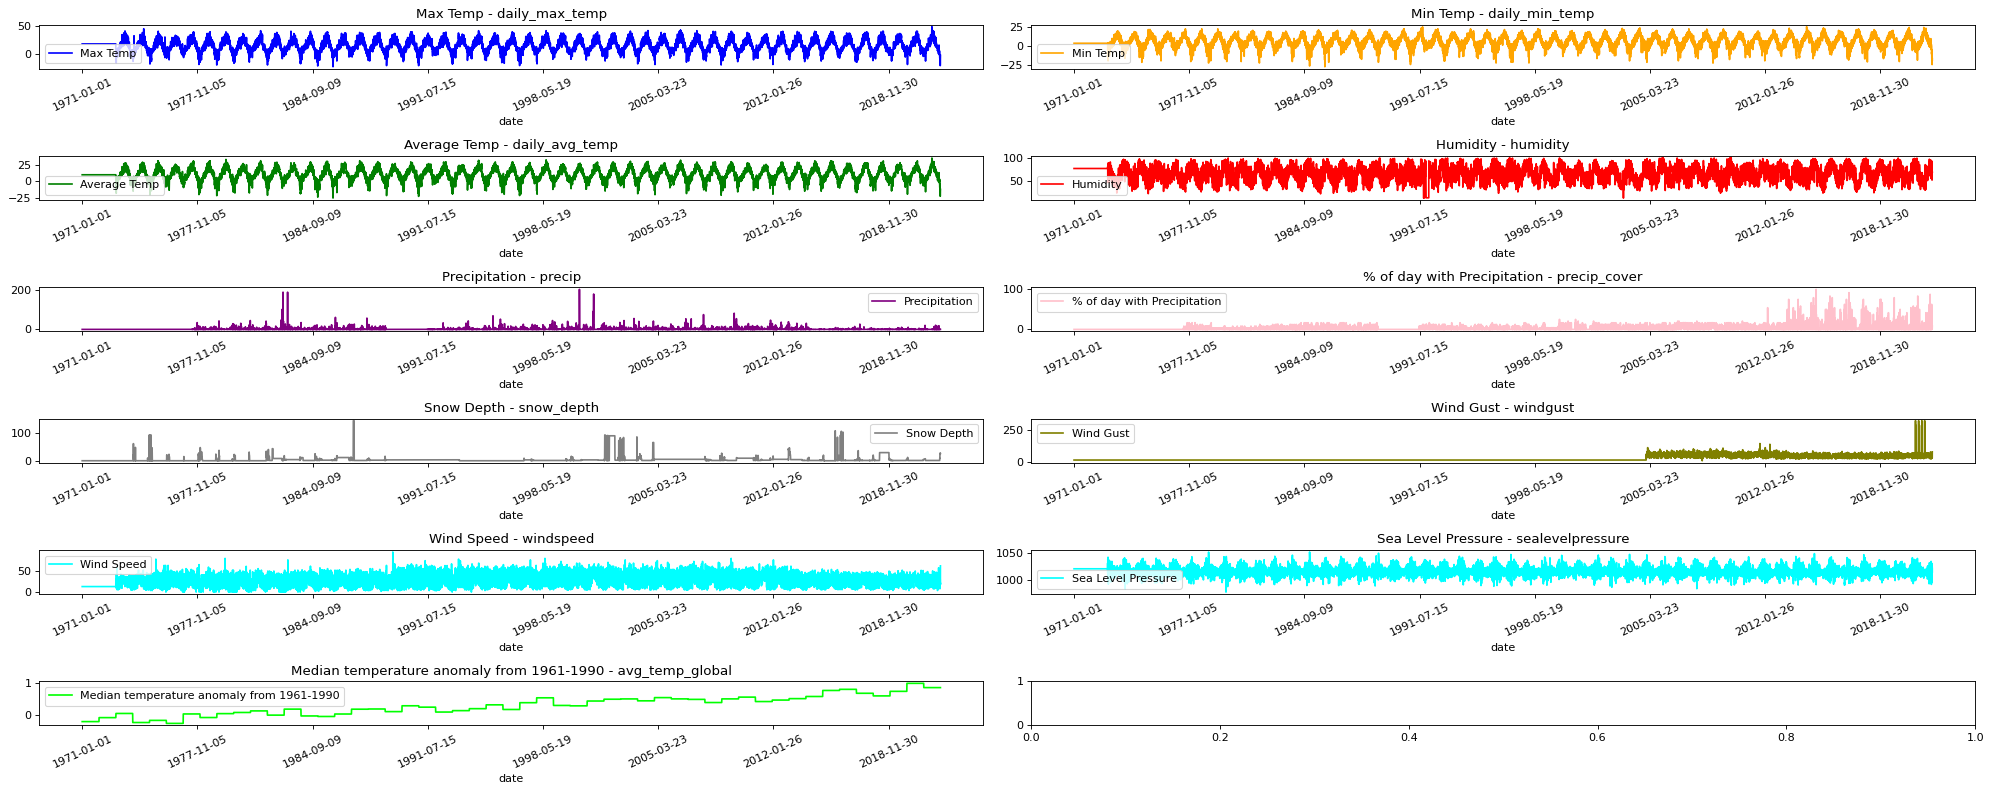

In [29]:
titles = [
    'Max Temp', 
    'Min Temp', 
    'Average Temp', 
    'Humidity', 
    'Precipitation',
    '% of day with Precipitation', 
    'Snow Depth', 
    'Wind Gust', 
    'Wind Speed',
    'Sea Level Pressure', 
    'Median temperature anomaly from 1961-1990'
]

feature_keys = [
    'daily_max_temp', 
    'daily_min_temp', 
    'daily_avg_temp', 
    'humidity',
    'precip', 
    'precip_cover', 
    'snow_depth', 
    'windgust', 
    'windspeed',
    'sealevelpressure', 
    'avg_temp_global'
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "pink",
    "gray",
    "olive",
    "cyan",
    "aqua",
    "lime"
]



def show_raw_visualization(data):
    time_data = data.index
    fig, axes = plt.subplots(
        nrows=6, ncols=2, figsize=(25, 10), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

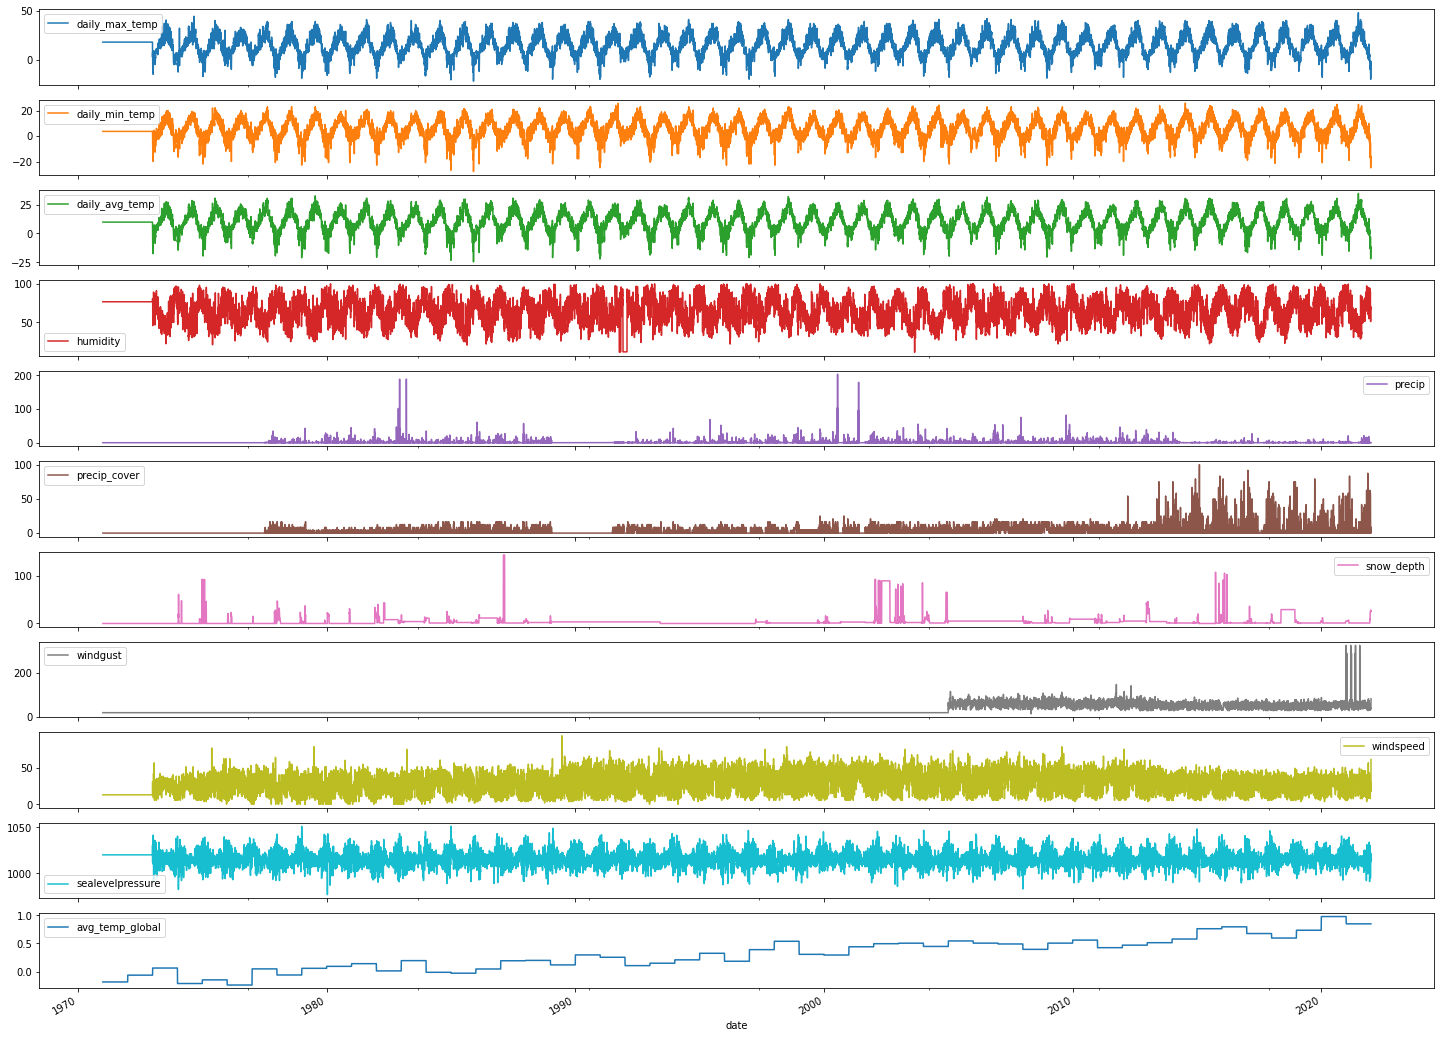

In [43]:
df.plot(subplots=True, figsize=(25,20))

### resample for 2 years for seasonality clarity

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

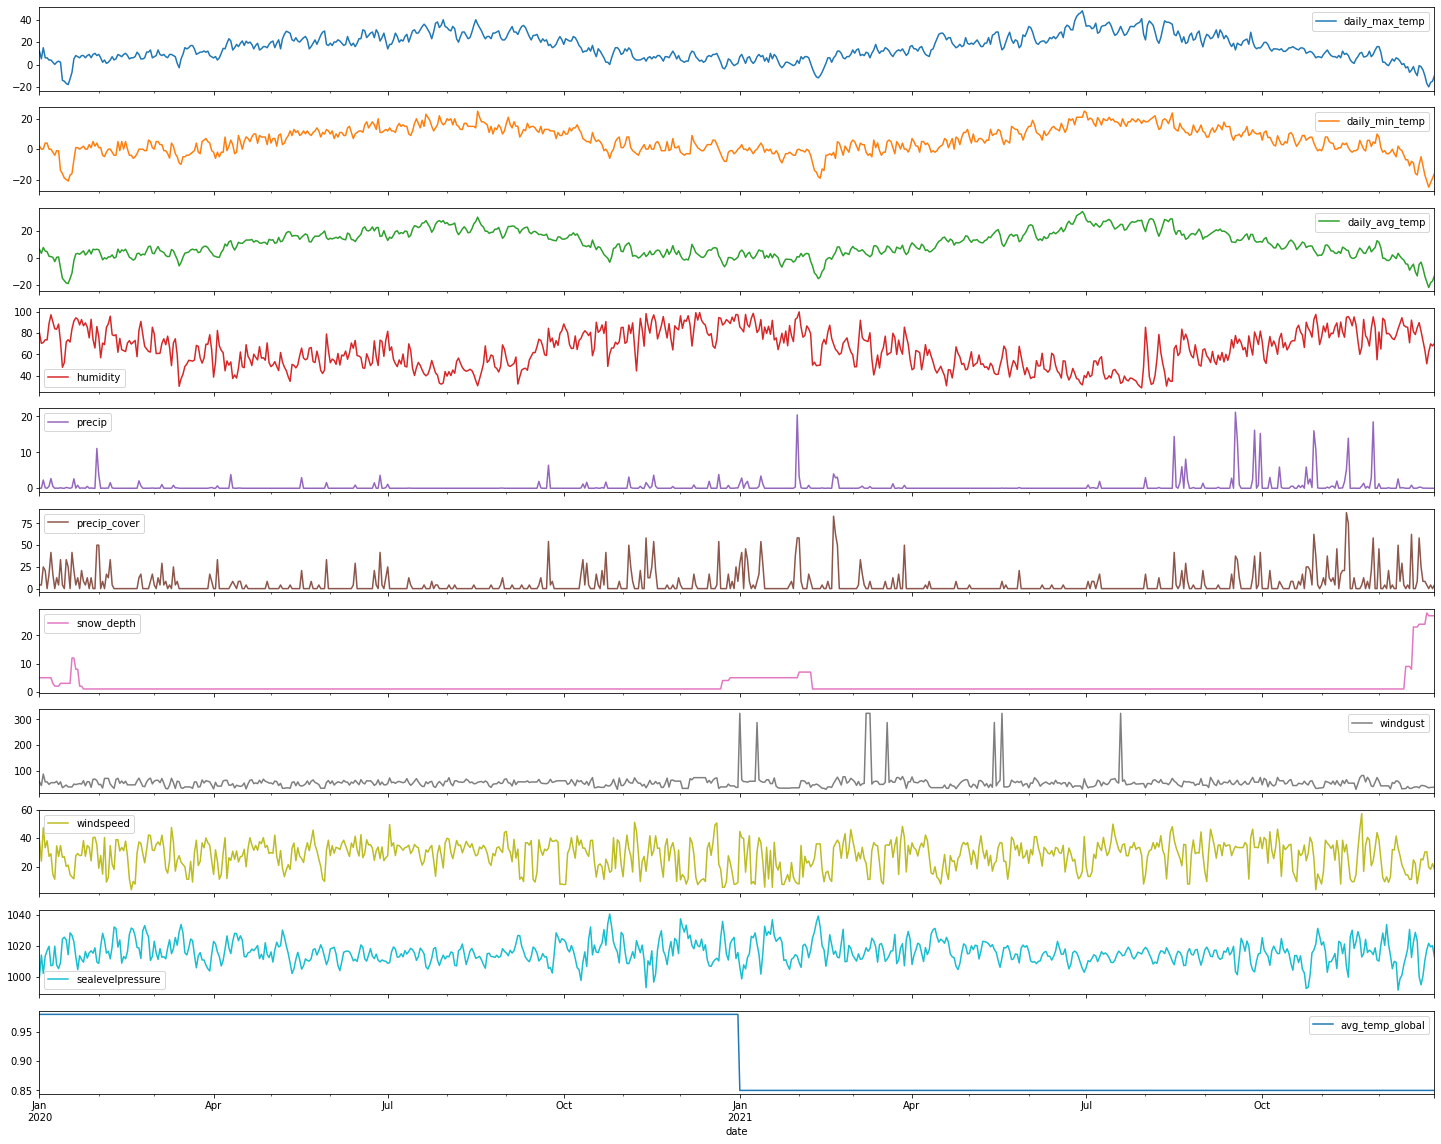

In [44]:
#plotting for 2 years, extra checks

df['2020':'2021'].resample('D').fillna(method='pad').plot(subplots=True, figsize=(25,20))


### histogram (skewness?)

array([[<AxesSubplot:title={'center':'daily_max_temp'}>,
        <AxesSubplot:title={'center':'daily_min_temp'}>,
        <AxesSubplot:title={'center':'daily_avg_temp'}>],
       [<AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'precip'}>,
        <AxesSubplot:title={'center':'precip_cover'}>],
       [<AxesSubplot:title={'center':'snow_depth'}>,
        <AxesSubplot:title={'center':'windgust'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'sealevelpressure'}>,
        <AxesSubplot:title={'center':'avg_temp_global'}>, <AxesSubplot:>]],
      dtype=object)

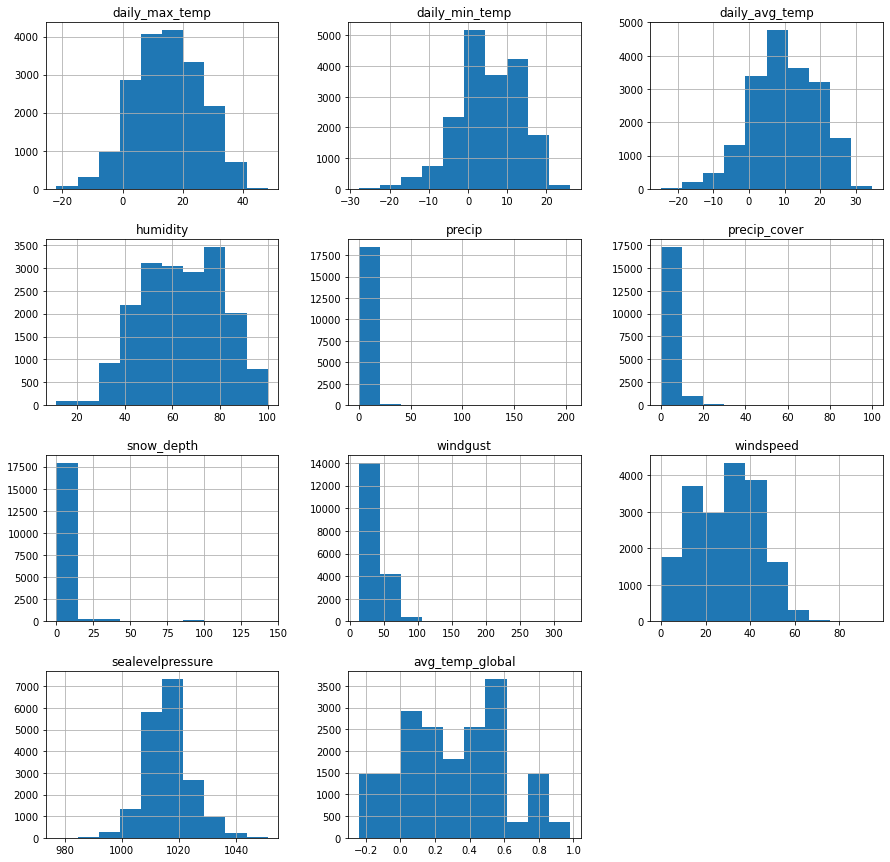

In [45]:
df.hist(bins=10,figsize=(15,15))

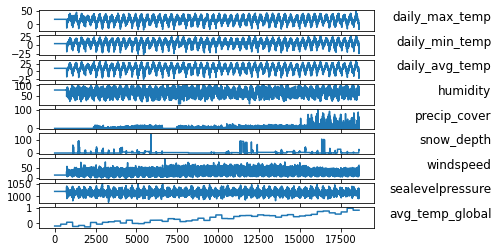

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

In [49]:
#simpler plot
from matplotlib import pyplot
# load dataset
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7, 8, 9]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.2, x=1.35, loc='right')
    i += 1
pyplot.show()
plt.figure(figsize=(20,5), dpi=100)

## observations 

### seasonality in:
1. temperature
2. humidity
3. sea level pressure

### trend in: 
1. precipitation cover
2. global median temperature anomoly

So I will have to make them stationary

*also need to look into wind speed?*



In [71]:
#first drop wind gust, missing too much data
df.drop(columns=['windgust'], inplace=True)

### when was the all time high temp since 1975? all time low? 

In [50]:
print(df.loc[df["daily_max_temp"] == df["daily_max_temp"].max()],'\n\n\n')
print(df.loc[df["daily_min_temp"] == df["daily_min_temp"].min()])

            daily_max_temp  daily_min_temp  daily_avg_temp  humidity  precip  \
date                                                                           
2021-06-29            48.1            21.0            34.7      31.4     0.0   

            precip_cover  snow_depth  windspeed  sealevelpressure  \
date                                                                
2021-06-29           0.0         1.0       16.7            1005.2   

            avg_temp_global  
date                         
2021-06-29             0.85   



            daily_max_temp  daily_min_temp  daily_avg_temp  humidity  precip  \
date                                                                           
1985-11-27           -21.9           -27.9           -24.8      57.7     0.0   

            precip_cover  snow_depth  windspeed  sealevelpressure  \
date                                                                
1985-11-27           0.0         1.0       35.3            1039.6   

        

### highest: 2021-06-29 48.1 degC
### lowest: 1985-11-27 -27.9 degC

### which features are most correlated? 

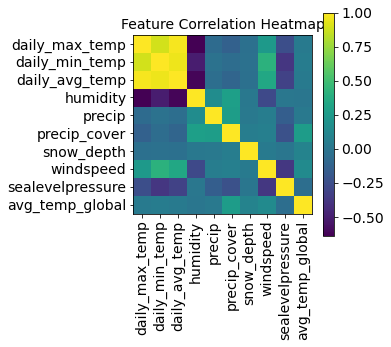

In [51]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

### notes: 
1. humidity has very little correlation with temperature 
2. windspeed appears to have decent correlation with temperature

# 2. Classic ML methods 

In [52]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

### target variable vs. entire dataset

In [72]:
weather_y=df["daily_max_temp"]
weather_x=df.drop(columns=['daily_max_temp'])

### split into train and test sets, train is before heat extreme event (2021-06-25), test is afterwards

In [74]:
train_X = weather_x['1971-01-01':'2021-06-25']
test_X = weather_x['2021-06-26':'2021-06-30']
train_y = weather_y['1971-01-01':'2021-06-25']
test_y = weather_y['2021-06-26':'2021-06-30']

In [75]:
train_X

,daily_min_temp,daily_avg_temp,humidity,precip,precip_cover,snow_depth,windspeed,sealevelpressure,avg_temp_global
date,,,,,,,,,
1971-01-01,3.7,9.8,76.8,0.0,0.0,0.0,13.0,1020.1,-0.186
1971-01-02,3.7,9.8,76.8,0.0,0.0,0.0,13.0,1020.1,-0.186
1971-01-03,3.7,9.8,76.8,0.0,0.0,0.0,13.0,1020.1,-0.186
1971-01-04,3.7,9.8,76.8,0.0,0.0,0.0,13.0,1020.1,-0.186
1971-01-05,3.7,9.8,76.8,0.0,0.0,0.0,13.0,1020.1,-0.186
...,...,...,...,...,...,...,...,...,...
2021-06-21,14.0,25.3,40.9,0.0,0.0,1.0,25.2,1010.2,0.850
2021-06-22,20.0,27.5,36.0,0.0,0.0,1.0,33.1,1005.0,0.850
2021-06-23,19.0,25.5,39.9,0.0,0.0,1.0,29.2,1007.9,0.850


### a) Linear Regression 

In [76]:
model=LinearRegression()
model.fit(train_X,train_y)

LinearRegression()

In [77]:
prediction = model.predict(test_X)

In [78]:
#calculating error
np.mean(np.absolute(prediction-test_y))

0.744315932316519

In [79]:
print('Variance score: %.2f' % model.score(test_X, test_y))

Variance score: 0.84


In [80]:
for i in range(len(prediction)):
    prediction[i]=round(prediction[i],2)
    pd.DataFrame({'Actual':test_y,'Prediction':prediction,'diff':(test_y-prediction)})

In [81]:
from sklearn.metrics import r2_score

print("Mean absolute error: %.2f" % np.mean(np.absolute(prediction - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((prediction - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y,prediction ) )

Mean absolute error: 0.74
Residual sum of squares (MSE): 0.75
R2-score: 0.84


In [82]:
prediction

array([42.44, 44.3 , 45.57, 47.91, 40.47])

### b) Ensemble: Random Forest Regression 

In [83]:
from sklearn.ensemble import RandomForestRegressor
regr=RandomForestRegressor(max_depth=90,random_state=0,n_estimators=100)
regr.fit(train_X,train_y)

RandomForestRegressor(max_depth=90, random_state=0)

In [84]:
prediction3=regr.predict(test_X)
np.mean(np.absolute(prediction3-test_y))

5.412800000000038

In [85]:
print('Variance score: %.2f' % regr.score(test_X, test_y))


Variance score: -6.32


In [86]:
for i in range(len(prediction3)):
  prediction3[i]=round(prediction3[i],2)
pd.DataFrame({'Actual':test_y,'Prediction':prediction3,'diff':(test_y-prediction3)})

,Actual,Prediction,diff
date,,,
2021-06-26,43.0,39.78,3.22
2021-06-27,45.1,39.74,5.36
2021-06-28,46.2,39.22,6.98
2021-06-29,48.1,39.06,9.04
2021-06-30,42.0,39.53,2.47


# 3. ARIMA univariate
## using only temperature

In [88]:
df_temp = df[["daily_max_temp"]]

In [89]:
df_temp.describe()

,daily_max_temp
count,18628.000000
mean,15.073282
std,10.834309
min,-21.900000
25%,7.100000
50%,15.100000
75%,23.000000
max,48.100000


#### missing some temp from before 1975, cut the dataset: 

In [90]:
df_temp = df_temp['1975-01-01':'2021-06-30']

#### now look at seasonality 

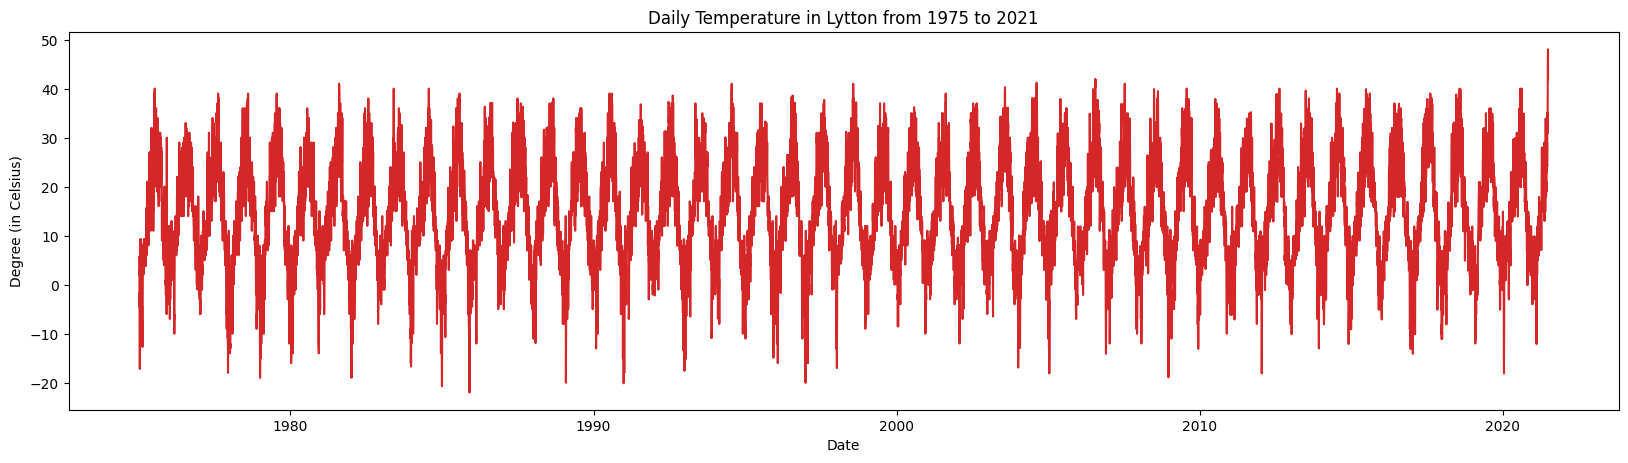

In [91]:
plt.figure(figsize=(20,5), dpi=100)
plt.plot(df_temp.index, df_temp['daily_max_temp'], color='tab:red')
plt.gca().set(title="Daily Temperature in Lytton from 1975 to 2021", xlabel='Date', ylabel="Degree (in Celsius)")
plt.show()

### non-stationary: decompose time series into its components 

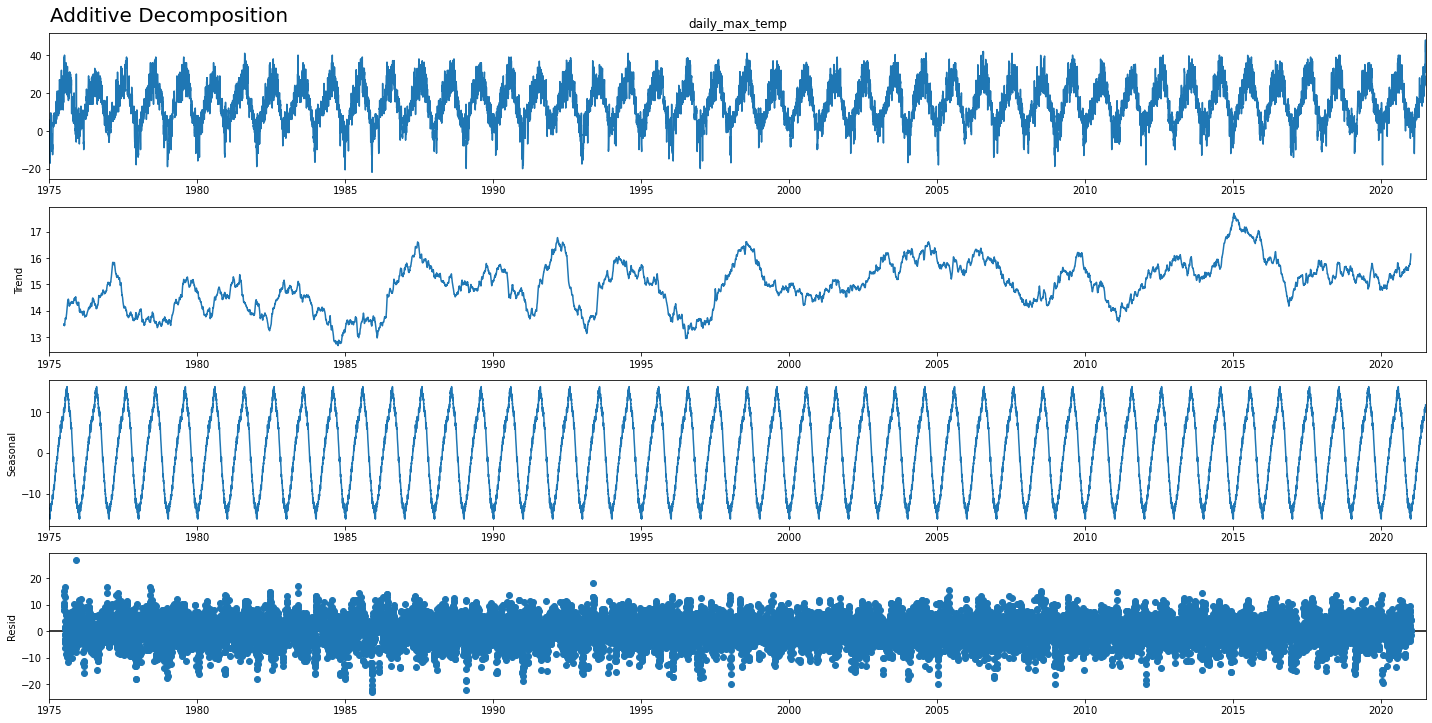

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(df_temp['daily_max_temp'], model='additive', period=365)

# Plot
plt.rcParams.update({'figure.figsize': (20,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=20, x = 0.12, y=1.0)
plt.show()

#### observed trend and seasonality

take a rolling window to clean seasonality

<AxesSubplot:xlabel='date'>

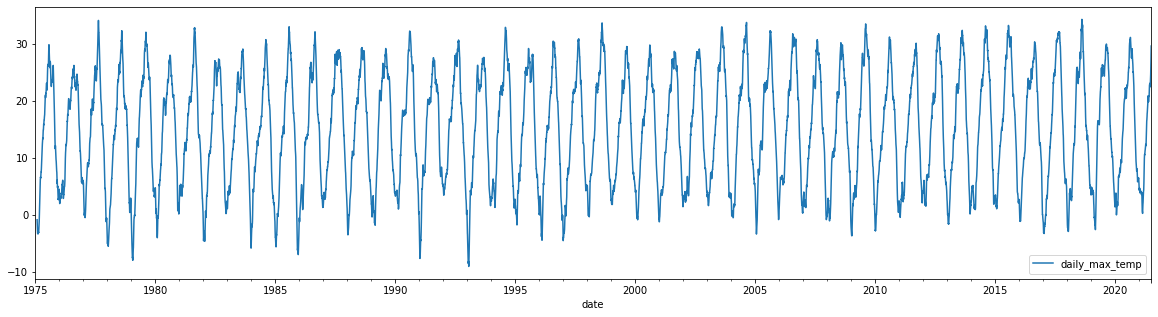

In [94]:
df_temp_mean = df_temp.rolling(window=30).mean()
df_temp_mean.plot(figsize=(20,5))

## Baseline Model - ARIMA univariate 

#### one-step forecasting

In [97]:
predicted_df = df_temp['daily_max_temp'].to_frame().shift(1).rename(columns = {"daily_max_temp": "temp_pred" })
actual_df = df_temp['daily_max_temp'].to_frame().rename(columns = {"daily_max_temp": "temp_actual" })
one_step_df = pd.concat([actual_df,predicted_df],axis=1)

In [98]:
temp_train = one_step_df[1:]

In [99]:
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

one_step_rmse = sqrt(MSE(temp_train.temp_actual, temp_train.temp_pred))

In [100]:
one_step_rmse

3.729495269662512

#### differencing to reduce seasonality

In [102]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff
 
# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

In [103]:
# difference the dataset
diff = difference(temp_train.temp_actual, 360)

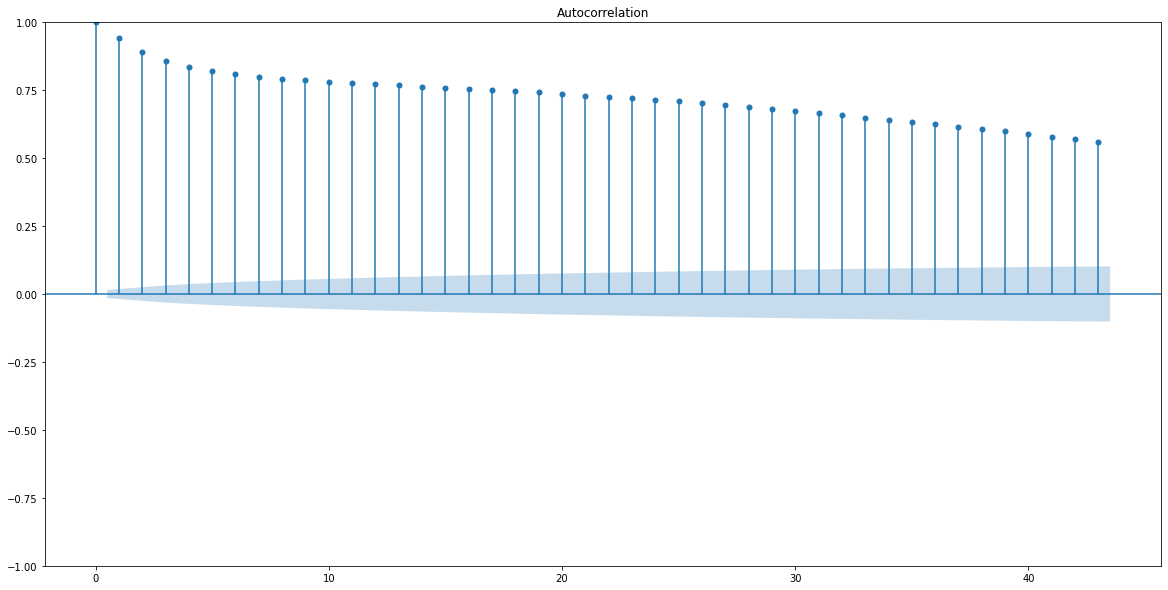

In [104]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the Autocorrelation graph
temp = temp_train["temp_actual"]
plot_acf(temp)
plt.rcParams["figure.figsize"] = (10,30)
pyplot.show()

/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


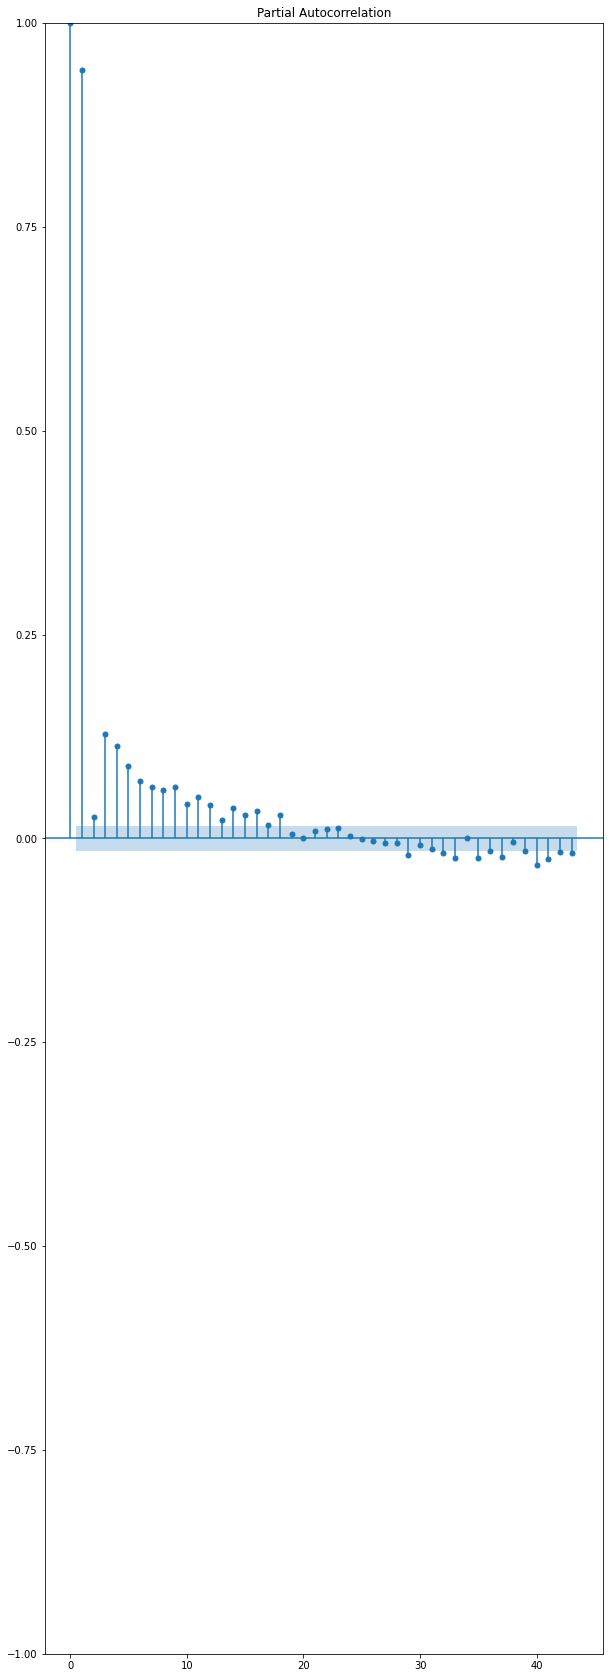

In [105]:
# Plot the Partial Autocorrelation graph
plot_pacf(temp)
pyplot.show()

### observations and resulting parameters: 

#### 1. AR should be 19 
#### 2. MA 0 
#### 3. I should be 0 (already differenced) 

### see how rmse changes the closer you get to date of prediction: 

predicted=29.768909, expected=38.900000
predicted=36.718084, expected=43.000000
predicted=39.556510, expected=45.100000
predicted=41.098676, expected=46.200000
predicted=42.395508, expected=48.100000
predicted=44.377097, expected=42.000000
7.0 days RMSE: 6.025


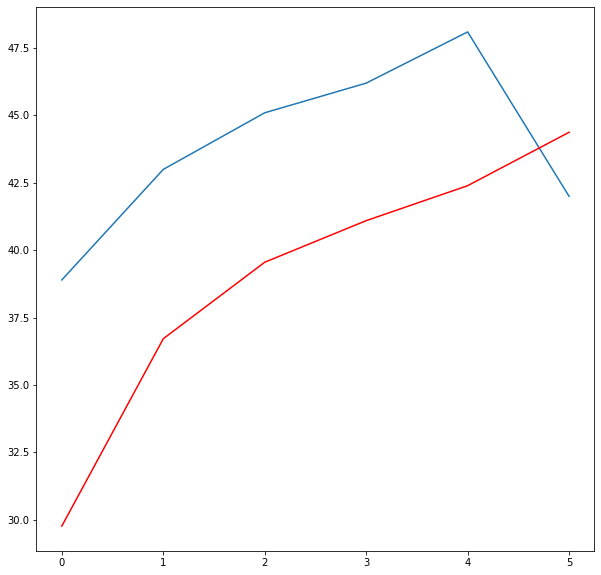

predicted=36.718084, expected=43.000000
predicted=39.556510, expected=45.100000
predicted=41.098676, expected=46.200000
predicted=42.395508, expected=48.100000
predicted=44.377097, expected=42.000000
6.0 days RMSE: 5.185


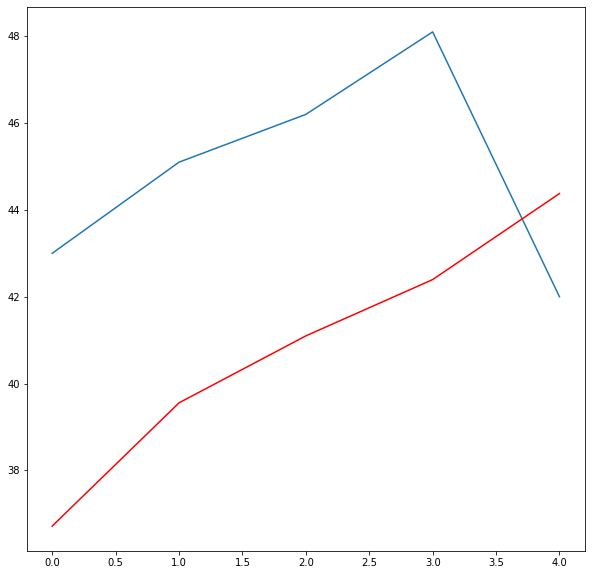

predicted=39.556510, expected=45.100000
predicted=41.098676, expected=46.200000
predicted=42.395508, expected=48.100000
predicted=44.377097, expected=42.000000
5.0 days RMSE: 4.872


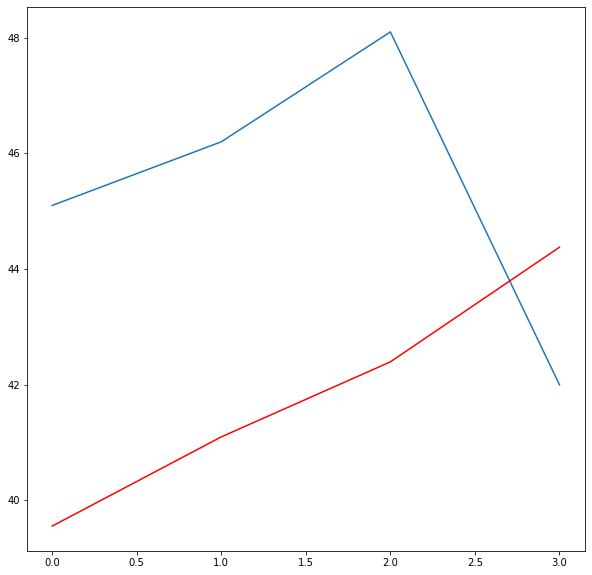

predicted=41.098676, expected=46.200000
predicted=42.395508, expected=48.100000
predicted=44.377097, expected=42.000000
4.0 days RMSE: 4.627


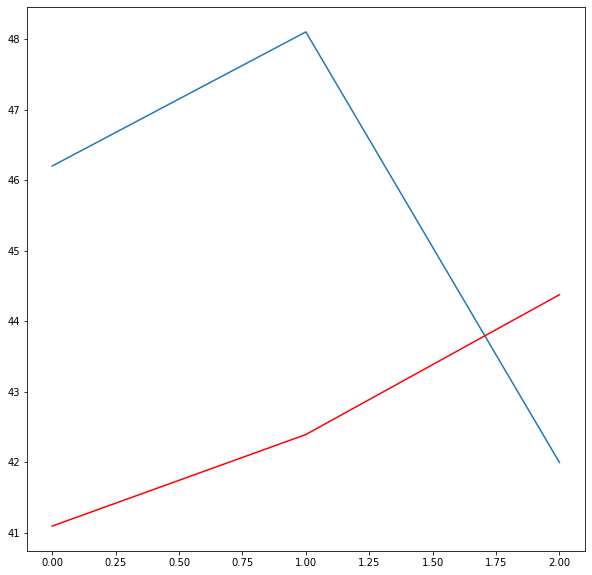

predicted=42.395508, expected=48.100000
predicted=44.377097, expected=42.000000
3.0 days RMSE: 4.370


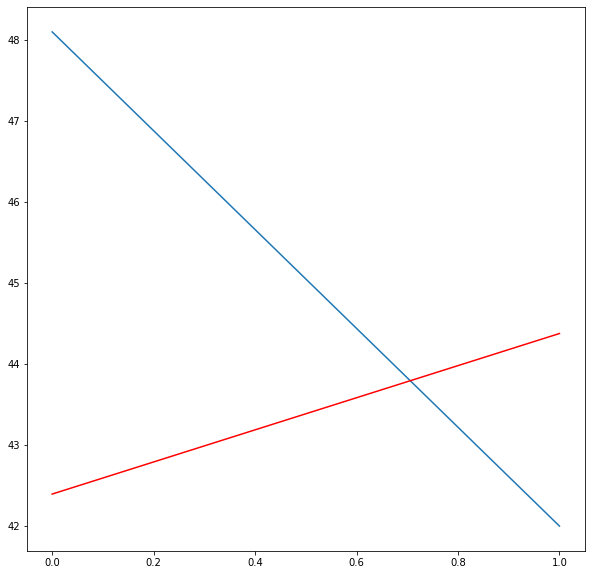

predicted=44.377097, expected=42.000000
2.0 days RMSE: 2.377


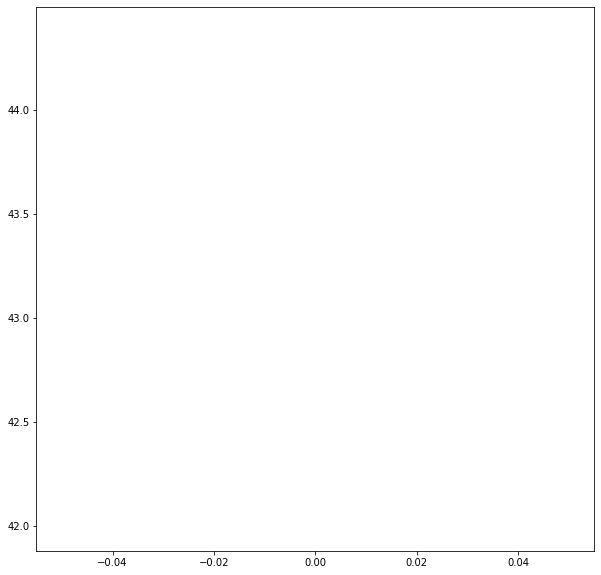

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [106]:
plt.rcParams["figure.figsize"] = (10,10)
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA

# split into train and test sets
X = temp.values

for i in range(16976,16984,1):
    size = i 
    days = 16983-i
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=(19,0,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    # evaluate forecasts
    rmse = sqrt(mean_squared_error(test, predictions))
    print('%.1f days RMSE: %.3f' % (days, rmse))
          
          
# plot forecasts against actual outcomes
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')

    pyplot.show()

# 4. ARIMA multivariate 

### using auto-arima

In [816]:
!pip install pmdarima

     |████████████████████████████████| 595 kB 11.0 MB/s eta 0:00:01


In [112]:
import pmdarima as pm

### Auto-Arima does not require stationary data!!!:)

#### let's do a stepwise gridsearch to arrive at best parameters

In [113]:
model = pm.auto_arima(df['daily_max_temp'], 
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=123243.412, Time=30.10 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=141637.509, Time=0.21 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=100731.296, Time=6.76 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=118268.627, Time=7.39 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=161696.816, Time=0.12 sec


/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=100752.216, Time=0.45 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=100719.697, Time=32.94 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=100704.995, Time=75.28 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=100704.413, Time=23.39 sec


/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=100732.505, Time=4.58 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=100704.937, Time=76.77 sec


/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=100721.940, Time=15.98 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=56.86 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=100692.975, Time=36.40 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=100718.370, Time=4.31 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=100717.309, Time=12.05 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=32.35 sec
 ARIMA(2,0,0)(1,0,2)[12] intercept   : AIC=100693.619, Time=80.29 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=100736.108, Time=0.55 sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=100708.644, Time=18.05 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=100706.703, Time=35.82 sec
 ARIMA(2,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=51.16 sec
 ARIMA(3,0,0)(1,0,1)[12] intercept   : AIC=100402.147, Time=55.02 sec
 ARIMA(3,0,0)(0,0,1)[12] intercept   : AIC=100418.109, Time=8.70 sec
 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=100417.572, Time=17.26 sec
 ARIMA(3,0,0)(2,0,1)[12] intercept   : AIC=i

/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(5,0,1)(0,0,2)[12] intercept   : AIC=99576.548, Time=82.20 sec


/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(5,0,1)(0,0,1)[12] intercept   : AIC=99579.667, Time=33.03 sec
 ARIMA(5,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=103.83 sec
 ARIMA(5,0,1)(1,0,1)[12] intercept   : AIC=99586.157, Time=47.64 sec
 ARIMA(4,0,1)(0,0,2)[12] intercept   : AIC=99574.570, Time=71.47 sec
 ARIMA(4,0,1)(0,0,1)[12] intercept   : AIC=99577.694, Time=25.67 sec
 ARIMA(4,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=94.10 sec
 ARIMA(4,0,1)(1,0,1)[12] intercept   : AIC=99570.167, Time=41.60 sec


/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,0,1)(1,0,0)[12] intercept   : AIC=99577.652, Time=34.38 sec
 ARIMA(4,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=95.03 sec


/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,0,1)(0,0,0)[12] intercept   : AIC=99577.394, Time=9.99 sec


/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,0,1)(2,0,0)[12] intercept   : AIC=99574.702, Time=92.82 sec
 ARIMA(4,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=104.45 sec
 ARIMA(3,0,1)(1,0,1)[12] intercept   : AIC=99569.127, Time=41.20 sec


/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(3,0,1)(0,0,1)[12] intercept   : AIC=99576.223, Time=21.78 sec


/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(1,0,0)[12] intercept   : AIC=99576.157, Time=33.14 sec
 ARIMA(3,0,1)(2,0,1)[12] intercept   : AIC=99634.445, Time=84.32 sec
 ARIMA(3,0,1)(1,0,2)[12] intercept   : AIC=99573.814, Time=83.26 sec


/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=99576.111, Time=8.29 sec


/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(3,0,1)(0,0,2)[12] intercept   : AIC=99573.075, Time=61.21 sec


/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(2,0,0)[12] intercept   : AIC=99582.211, Time=95.02 sec
 ARIMA(3,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=111.63 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=100699.836, Time=30.33 sec
 ARIMA(3,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=41.63 sec
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=36.99 sec
 ARIMA(4,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=40.11 sec
 ARIMA(3,0,1)(1,0,1)[12]             : AIC=inf, Time=18.12 sec

Best model:  ARIMA(3,0,1)(1,0,1)[12] intercept
Total fit time: 2710.741 seconds


### split into train, test (history, prediction)

In [114]:
train=df[(df.index.get_level_values(0) >= '1971-01-01') & (df.index.get_level_values(0) <= '2021-06-24')]
test=df[(df.index.get_level_values(0) >= '2021-06-26') & (df.index.get_level_values(0) <= '2021-06-30')]

#### fit and predict model

In [115]:
model.fit(train['daily_max_temp'])

ARIMA(order=(3, 0, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

In [116]:
forecast=model.predict(n_periods=5, return_conf_int=True)

In [117]:
forecast_df = pd.DataFrame(forecast[0],index = test.index,columns=['Prediction'])

#### arrive at temp predictions

In [118]:
forecast_df

,Prediction
date,
2021-06-26,30.015169
2021-06-27,29.292399
2021-06-28,28.779629
2021-06-29,28.478637
2021-06-30,28.190668


<AxesSubplot:xlabel='date'>

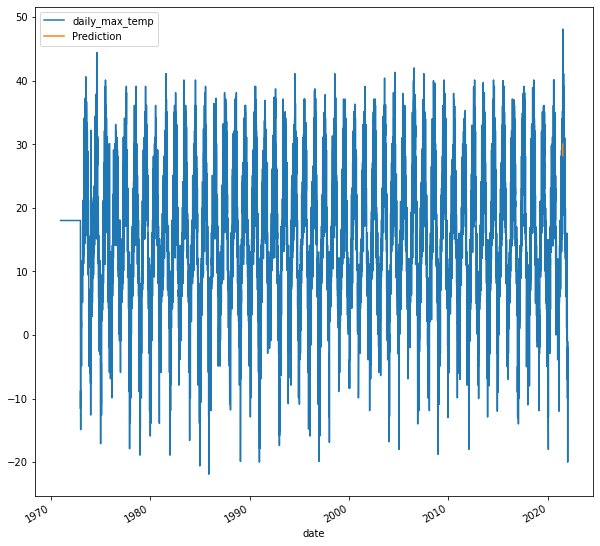

In [119]:
pd.concat([df['daily_max_temp'],forecast_df],axis=1).plot()
#lol can't really see this oh well 

In [120]:
forecast1=model.predict(n_periods=5, return_conf_int=True)
forecast_range=pd.date_range(start='2021-06-25', periods=5,freq='D')

In [121]:
forecast1_df = pd.DataFrame(forecast1[0],index =forecast_range,columns=['Prediction'])


<AxesSubplot:>

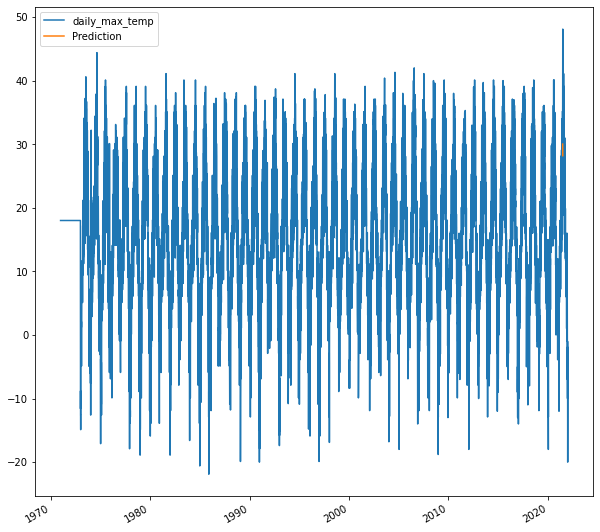

In [122]:
pd.concat([df['daily_max_temp'],forecast1_df],axis=1).plot()


In [123]:
#let's look at numbers instead 
forecast1_df

,Prediction
2021-06-25,30.015169
2021-06-26,29.292399
2021-06-27,28.779629
2021-06-28,28.478637
2021-06-29,28.190668


# 5. FB prophet

In [420]:
from prophet import Prophet

#### rename columns

In [424]:
df_prophet = df_temp.reset_index().rename(columns={'date':'ds','daily_max_temp':'y'})

In [425]:
df_prophet

,ds,y
0,1975-01-01,5.7
1,1975-01-02,5.7
2,1975-01-03,5.7
3,1975-01-04,2.2
4,1975-01-05,2.9
...,...,...
16978,2021-06-26,43.0
16979,2021-06-27,45.1
16980,2021-06-28,46.2
16981,2021-06-29,48.1


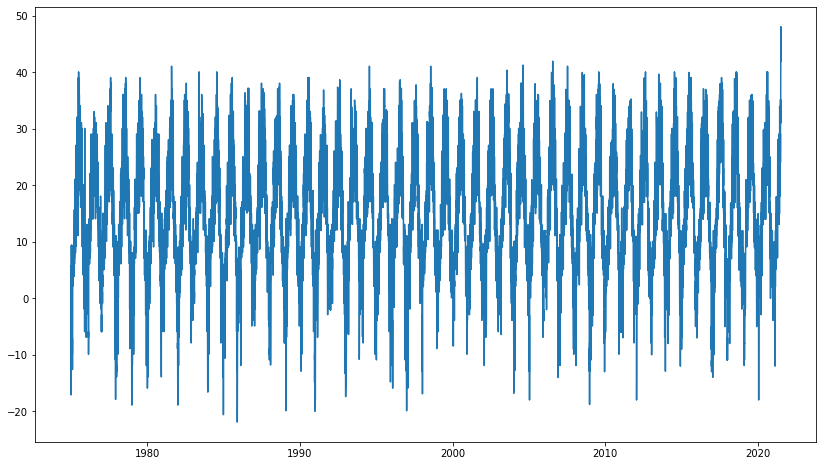

In [426]:
plt.figure(figsize = (14,8))
plt.plot(df_prophet['ds'],df_prophet['y'])
plt.show()

In [439]:
train_prophet = df_prophet[:16976].copy(deep=True)
test_prophet = df_prophet[16976:].copy(deep=True)

In [428]:
# Initialize Model
m = Prophet(interval_width = 0.95, daily_seasonality= False)

### Fourier order helps with seasonality. 3 for weekly seasonality and 10 for yearly seasonality

In [429]:
m.add_seasonality(name="monthly",period=30.5,fourier_order=5)

In [431]:
# Fit Model
m.fit(train_prophet)

/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -868.677


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         27338    0.00429282       123.273           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       27341.4    0.00096054       429.747      0.3168      0.7806      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       27342.7   7.95484e-05        123.07   3.183e-07       0.001      346  LS failed, Hessian reset 
     299       27343.4   1.40509e-05       59.4928      0.6733      0.6733      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344       27343.5   0.000341149       159.101   3.698e-06       0.001      497  LS failed, Hessian reset 
     390       27343.6   3.10273e-05       57.1687    3.81e-07       0.001      593  LS failed, Hessian reset 
     399       27343.6   5.74179e-06  

#### predict the future by 60 timesteps
#### includes the Train Dates + 60 days 

In [783]:
# Future Date
future_dates = m.make_future_dataframe(periods=7) 
future_dates   

,ds
0,1975-01-01
1,1975-01-02
2,1975-01-03
3,1975-01-04
4,1975-01-05
...,...
16978,2021-06-26
16979,2021-06-27
16980,2021-06-28
16981,2021-06-29


In [784]:
# Prediction
prediction =  m.predict(future_dates)

/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


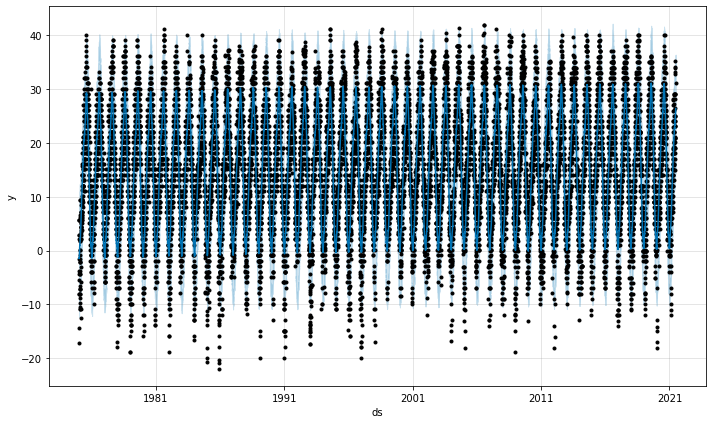

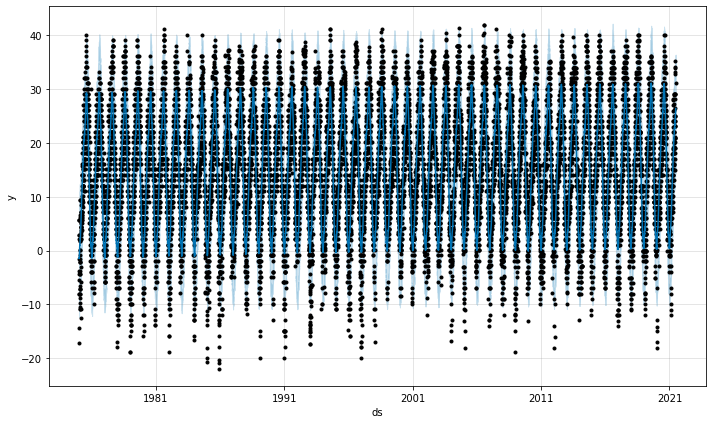

In [785]:
# Plot Prediction
m.plot(prediction) 

### plot total, day of week, day of year, day of month seasonality

/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


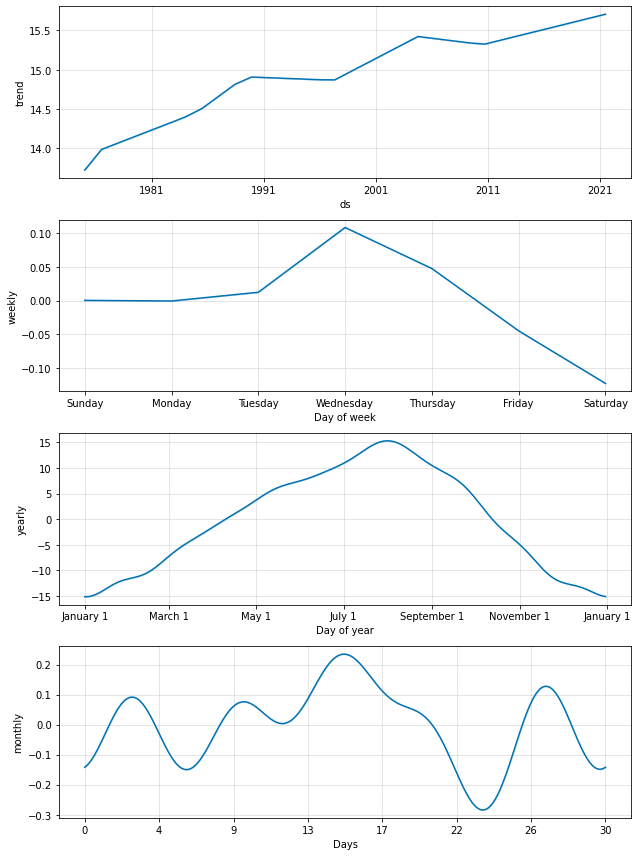

In [786]:
m.plot_components(prediction);

In [787]:
test_prophet['dates'] = pd.to_datetime(test_prophet['ds'])

In [788]:
# Find Point/Dates For Change
from prophet.plot import add_changepoints_to_plot

### red lines are major changepoints in trend of temperature

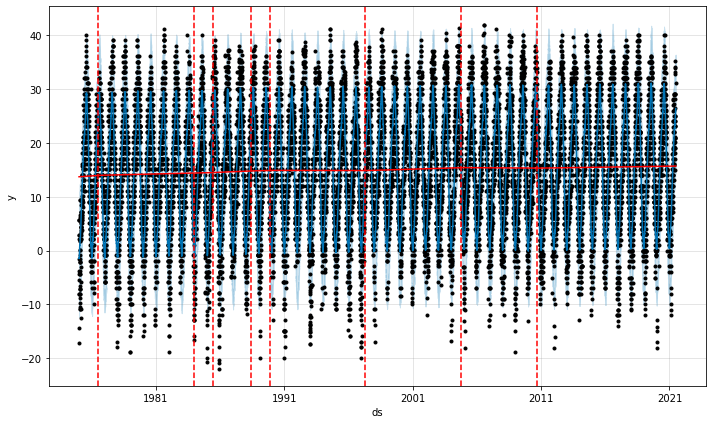

In [789]:
fig = m.plot(prediction)
c = add_changepoints_to_plot(fig.gca(),m,prediction)

In [790]:
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1975-01-01,13.725131,-11.197986,9.833360,13.725131,13.725131,-15.136359,-15.136359,-15.136359,-0.108031,...,0.107955,0.107955,0.107955,-15.136283,-15.136283,-15.136283,0.0,0.0,0.0,-1.411228
1,1975-01-02,13.725614,-11.755508,8.606608,13.725614,13.725614,-15.098136,-15.098136,-15.098136,0.006335,...,0.047341,0.047341,0.047341,-15.151812,-15.151812,-15.151812,0.0,0.0,0.0,-1.372522
2,1975-01-03,13.726097,-12.338662,8.482760,13.726097,13.726097,-15.106070,-15.106070,-15.106070,0.087452,...,-0.044748,-0.044748,-0.044748,-15.148774,-15.148774,-15.148774,0.0,0.0,0.0,-1.379974
3,1975-01-04,13.726579,-11.313485,8.009133,13.726579,13.726579,-15.188153,-15.188153,-15.188153,0.061100,...,-0.122432,-0.122432,-0.122432,-15.126822,-15.126822,-15.126822,0.0,0.0,0.0,-1.461574
4,1975-01-05,13.727062,-11.076350,8.330484,13.727062,13.727062,-15.132406,-15.132406,-15.132406,-0.046786,...,0.000306,0.000306,0.000306,-15.085925,-15.085925,-15.085925,0.0,0.0,0.0,-1.405344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16978,2021-06-26,15.706007,16.115223,35.868174,15.706007,15.706007,10.099260,10.099260,10.099260,-0.012834,...,-0.122432,-0.122432,-0.122432,10.234526,10.234526,10.234526,0.0,0.0,0.0,25.805267
16979,2021-06-27,15.706104,15.966003,36.415246,15.706104,15.706104,10.242155,10.242155,10.242155,-0.124036,...,0.000306,0.000306,0.000306,10.365886,10.365886,10.365886,0.0,0.0,0.0,25.948259
16980,2021-06-28,15.706200,16.083778,35.436448,15.706200,15.706200,10.256394,10.256394,10.256394,-0.243305,...,-0.000648,-0.000648,-0.000648,10.500347,10.500347,10.500347,0.0,0.0,0.0,25.962595
16981,2021-06-29,15.706297,15.245359,36.285118,15.706297,15.706297,10.368431,10.368431,10.368431,-0.282074,...,0.012226,0.012226,0.012226,10.638278,10.638278,10.638278,0.0,0.0,0.0,26.074727


In [ ]:
lytton_week = 16976